In [4]:
#Import thr required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pysal.lib import weights
from esda import Moran, Geary
from sklearn.neighbors import kneighbors_graph
from mpl_toolkits.mplot3d import Axes3D
import gstools as gs
from sklearn.metrics import mean_squared_error,mean_absolute_error
from pykrige.ok import OrdinaryKriging

from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import libpysal as lp
from esda.moran import Moran_BV
from scipy.interpolate import griddata
import pysal as ps

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import cm

In [5]:
#Convert data to dataframe
def read_data_to_df(file_path, group_size=266, skip_rows=6):

    all_values = []

    with open(file_path, 'r') as file:
        for _ in range(skip_rows):
            next(file)

        for line in file:
            values = [float(val) for val in line.strip().split()]
            all_values.extend(values)

    num_columns = len(all_values) // group_size

    if len(all_values) % group_size != 0:
        raise ValueError(f"error")

    df = pd.DataFrame(columns=range(num_columns))

    for i in range(0, len(all_values), group_size):
        col_index = i // group_size
        df[col_index] = all_values[i:i + group_size]

    df = df.T

    return df


In [6]:
file_paths = [
    'D:/ShuweiCup/Attachment 1/F1_target_variable.txt',
    'D:/ShuweiCup/Attachment 1/F1_collaborative_variable1.txt',
    'D:/ShuweiCup/Attachment 1/F1_collaborative_variable2.txt',
    'D:/ShuweiCup/Attachment 1/F1_collaborative_variable3.txt',
    'D:/ShuweiCup/Attachment 1/F1_collaborative_variable4.txt',
    'D:/ShuweiCup/Attachment 2/F2_collaborative_variable1.txt',
    'D:/ShuweiCup/Attachment 2/F2_collaborative_variable2.txt',
    'D:/ShuweiCup/Attachment 2/F2_collaborative_variable3.txt',
    'D:/ShuweiCup/Attachment 2/F2_collaborative_variable4.txt'
]

for file_path in file_paths:
    try:
        df = read_data_to_df(file_path, skip_rows=6)

        file_name = file_path.split('\\')[-1].split('.')[0]

        print(f"Processing file: {file_name}")
        print(df.head())

        output_file = f'{file_name}_output.csv'
        df.to_csv(output_file, index=False)
        print(f"Saved to: {output_file}\n")

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

Error processing file D:/ShuweiCup/Attachment 1/F1_target_variable.txt: 'gbk' codec can't decode byte 0x9a in position 20: illegal multibyte sequence
Processing file: D:/ShuweiCup/Attachment 1/F1_collaborative_variable1
        0         1         2         3         4         5         6    \
0  373.0228  372.1023  371.1602  370.1951  369.2138  368.2181  367.2090   
1  372.3001  371.4718  370.6194  369.7416  368.8435  367.9277  366.9948   
2  371.6777  370.9422  370.1781  369.3887  368.5737  367.7356  366.8798   
3  371.1478  370.5042  369.8296  369.1265  368.3961  367.6382  366.8585   
4  370.7044  370.1535  369.5691  368.9527  368.3049  367.6277  366.9273   

        7         8         9    ...       256       257       258       259  \
0  366.1871  365.1606  364.1306  ...  420.7905  405.4846  389.7867  373.7014   
1  366.0463  365.0891  364.1261  ...  440.4447  425.2642  409.6828  393.7228   
2  366.0056  365.1197  364.2241  ...  459.6932  444.6194  429.1542  413.3035   
3  366.05

Question 1

In [7]:
#(1)
F1_target_variable = pd.read_csv("D:/ShuweiCup/Attachment 1/F1_target_variable.csv")

In [8]:
num_columns = F1_target_variable.shape[1]
new_column_names = ['V' + str(i) for i in range(num_columns)]
F1_target_variable.columns = new_column_names

F1_target_variable.head(5)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265
0,0.5269,0.5271,0.5272,0.5274,0.5275,0.5277,0.5278,0.5279,0.5281,0.5282,...,0.4750,0.4745,0.4741,0.4736,0.4730,0.4725,0.4720,0.4714,0.4709,0.4703
1,0.5279,0.5280,0.5281,0.5283,0.5284,0.5285,0.5287,0.5288,0.5289,0.5290,...,0.4763,0.4759,0.4754,0.4749,0.4744,0.4739,0.4733,0.4728,0.4722,0.4716
2,0.5288,0.5289,0.5290,0.5292,0.5293,0.5294,0.5295,0.5296,0.5297,0.5299,...,0.4776,0.4772,0.4767,0.4762,0.4757,0.4752,0.4747,0.4741,0.4736,0.4730
3,0.5297,0.5298,0.5299,0.5300,0.5302,0.5303,0.5304,0.5305,0.5306,0.5307,...,0.4789,0.4785,0.4780,0.4775,0.4770,0.4765,0.4760,0.4754,0.4749,0.4743
4,0.5306,0.5307,0.5308,0.5309,0.5310,0.5311,0.5312,0.5313,0.5314,0.5315,...,0.4802,0.4797,0.4793,0.4788,0.4783,0.4778,0.4772,0.4767,0.4762,0.4756


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_7784\2435664813.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


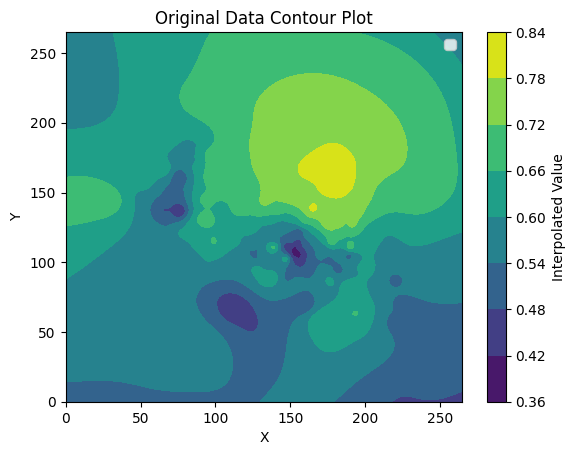

In [9]:
#contour map of original data:F1 target 

rows, cols = F1_target_variable.shape

X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
Z = F1_target_variable.values

grid_x, grid_y = np.mgrid[0:266, 0:266]
grid_z = np.zeros((266, 266))
contour = plt.contourf(X,Y,Z, cmap='viridis')
plt.colorbar(contour, label='Interpolated Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data Contour Plot')
plt.legend()
plt.show()

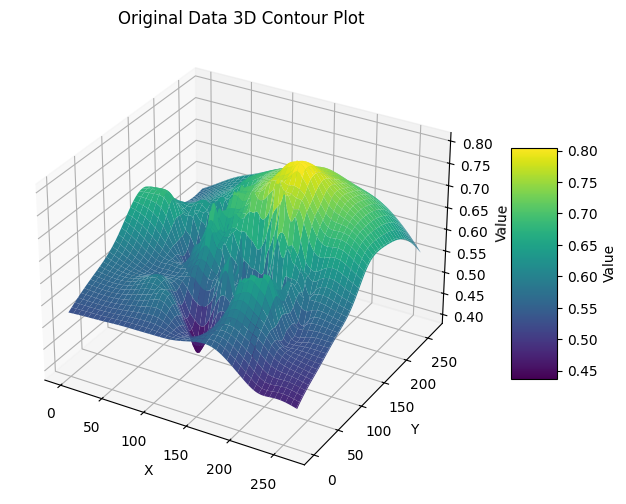

In [10]:
#3D contour map

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

contour = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

fig.colorbar(contour, shrink=0.5, aspect=5, label='Value')

ax.set_title('Original Data 3D Contour Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')

plt.show()

In [11]:
#Convert the read dataframes into dictionaries

def convert_df_to_dict_list(df):
    dict_list = []

    rows, cols = df.shape

    for x in range(rows):
        for y in range(cols):
            value = df.iloc[x, y]
            data_dict = {
                'aij': value,
                'x': x,
                'y': y,
                'type': 'original' 
            }
            dict_list.append(data_dict)

    return dict_list

dic_list_F1_target = convert_df_to_dict_list(F1_target_variable)

In [12]:
dic_list_F1_target

[{'aij': 0.5269, 'x': 0, 'y': 0, 'type': 'original'},
 {'aij': 0.5271, 'x': 0, 'y': 1, 'type': 'original'},
 {'aij': 0.5272, 'x': 0, 'y': 2, 'type': 'original'},
 {'aij': 0.5274, 'x': 0, 'y': 3, 'type': 'original'},
 {'aij': 0.5275, 'x': 0, 'y': 4, 'type': 'original'},
 {'aij': 0.5277, 'x': 0, 'y': 5, 'type': 'original'},
 {'aij': 0.5278, 'x': 0, 'y': 6, 'type': 'original'},
 {'aij': 0.5279, 'x': 0, 'y': 7, 'type': 'original'},
 {'aij': 0.5281, 'x': 0, 'y': 8, 'type': 'original'},
 {'aij': 0.5282, 'x': 0, 'y': 9, 'type': 'original'},
 {'aij': 0.5283, 'x': 0, 'y': 10, 'type': 'original'},
 {'aij': 0.5285, 'x': 0, 'y': 11, 'type': 'original'},
 {'aij': 0.5286, 'x': 0, 'y': 12, 'type': 'original'},
 {'aij': 0.5287, 'x': 0, 'y': 13, 'type': 'original'},
 {'aij': 0.5288, 'x': 0, 'y': 14, 'type': 'original'},
 {'aij': 0.5289, 'x': 0, 'y': 15, 'type': 'original'},
 {'aij': 0.529, 'x': 0, 'y': 16, 'type': 'original'},
 {'aij': 0.5292, 'x': 0, 'y': 17, 'type': 'original'},
 {'aij': 0.5293, 'x':

In [13]:
dic_df_F1_target = pd.DataFrame(dic_list_F1_target)
dic_df_F1_target.head(5)

,aij,x,y,type
0,0.5269,0,0,original
1,0.5271,0,1,original
2,0.5272,0,2,original
3,0.5274,0,3,original
4,0.5275,0,4,original


   Sample  Moran's I  Moran P-value  Geary's C  Geary P-value
0       1   0.998247          0.001   0.001714          0.001
1       2   0.998321          0.001   0.001737          0.001
2       3   0.998216          0.001   0.001708          0.001
3       4   0.998390          0.001   0.001738          0.001
4       5   0.998425          0.001   0.001731          0.001
5       6   0.998271          0.001   0.001742          0.001
6       7   0.998431          0.001   0.001715          0.001
7       8   0.998293          0.001   0.001732          0.001
8       9   0.998345          0.001   0.001749          0.001
9      10   0.998473          0.001   0.001724          0.001


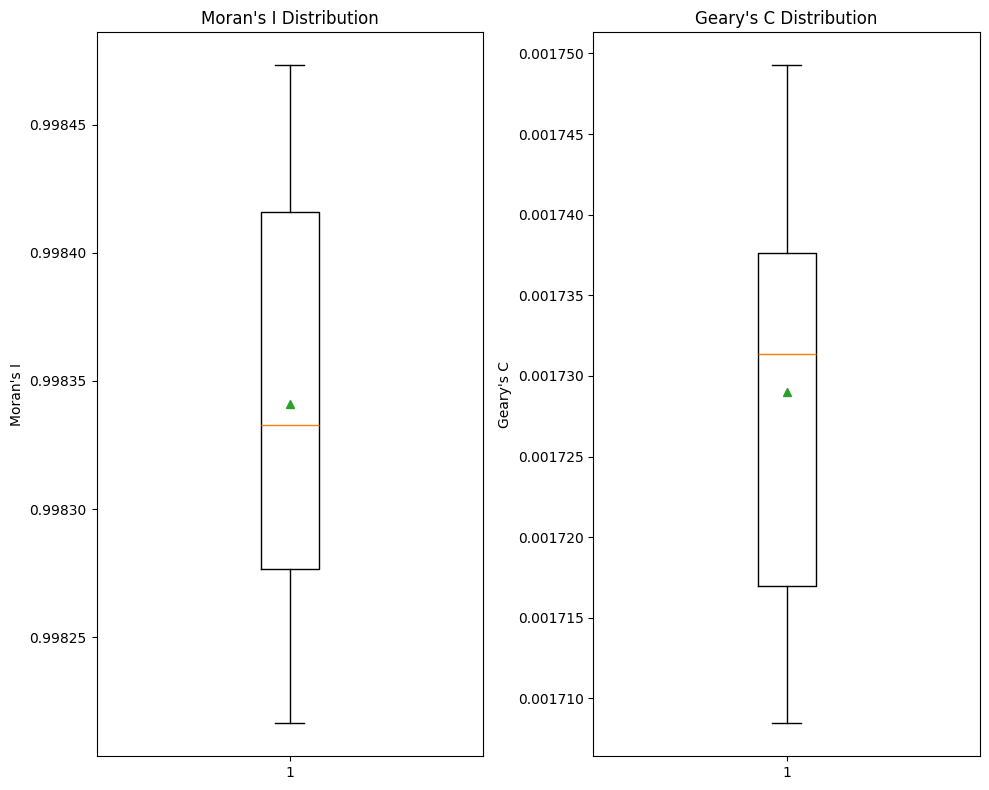

In [14]:
#Autocorrelation sampling test

sample_size = 40000
num_samples = 10 
k = 10  

autocorr_results = []

for i in range(num_samples):
    df_sampled = dic_df_F1_target.sample(n=sample_size, random_state=i)

    coordinates = df_sampled[['x', 'y']].values
    knn_graph = kneighbors_graph(coordinates, k, mode='connectivity', include_self=True)

    w = weights.W.from_sparse(knn_graph)

    w.transform = 'r'  

    values = df_sampled['aij'].values

    #calculate Moran's I
    moran = Moran(values, w)
    moran_I = moran.I
    moran_p = moran.p_sim

    #calculate Geary's C
    geary = Geary(values, w)
    geary_C = geary.C
    geary_p = geary.p_sim

    autocorr_results.append({
        'Sample': i + 1,
        'Moran\'s I': moran_I,
        'Moran P-value': moran_p,
        'Geary\'s C': geary_C,
        'Geary P-value': geary_p
    })

df_autocorr_results = pd.DataFrame(autocorr_results)

print(df_autocorr_results)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.boxplot(df_autocorr_results['Moran\'s I'], showmeans=True)
plt.title('Moran\'s I Distribution')
plt.ylabel('Moran\'s I')

plt.subplot(1, 2, 2)
plt.boxplot(df_autocorr_results['Geary\'s C'], showmeans=True)
plt.title('Geary\'s C Distribution')
plt.ylabel('Geary\'s C')

plt.tight_layout()
plt.show()

# df_autocorr_results.to_csv("D:/desktop/autocorrelatuion sampling results.csv", index=False)

In [15]:
#Resample

sample_ratio = 0.01  
np.random.seed(0)

coordinates = [(d['x'], d['y']) for d in dic_list_F1_target]

sample_indices = np.random.choice(len(coordinates), int(sample_ratio * len(coordinates)), replace=False)
sample_coordinates = [coordinates[i] for i in sample_indices]

train_data = [d for d in dic_list_F1_target if (d['x'], d['y']) in sample_coordinates]
test_data = [d for d in dic_list_F1_target if (d['x'], d['y']) not in sample_coordinates]

for d in train_data:
    d['type'] = 'sample'

X_train = np.array([[d['x'], d['y']] for d in train_data], dtype=float)
y_train = np.array([d['aij'] for d in train_data], dtype=float)
X_test = np.array([[d['x'], d['y']] for d in test_data], dtype=float)
y_test = np.array([d['aij'] for d in test_data], dtype=float)

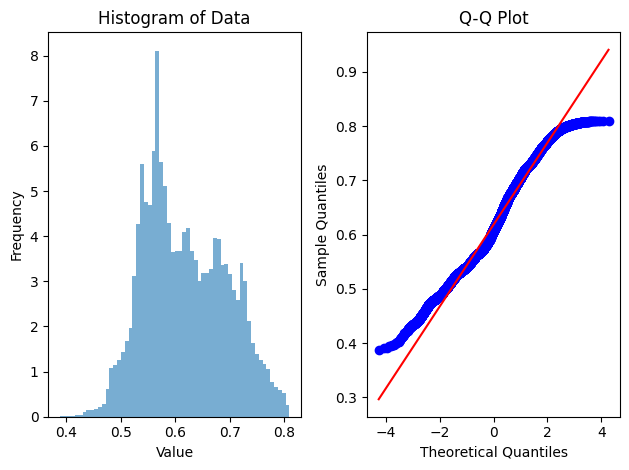

In [ ]:
#Normality test

from scipy.stats import boxcox

if_normal = F1_target_variable.values.flatten()

transformed_data = if_normal

plt.subplot(1, 2, 1)
plt.hist(transformed_data, bins=60, density=True, alpha=0.6)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# draw Q-Q picture
plt.subplot(1, 2, 2)
stats.probplot(transformed_data, dist="norm", plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [17]:
#Anderson-Darling test (A-D test)
from scipy.stats import anderson
result = anderson(transformed_data, dist='norm')
print(result)

AndersonResult(statistic=590.8416980968614, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.6185998558426142, scale=0.07630380214465288)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


c:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Spherical model RMSE: 0.008496157928515855
Linear model RMSE: 0.026214823983787394
Gaussian model RMSE: 0.012006039238753539


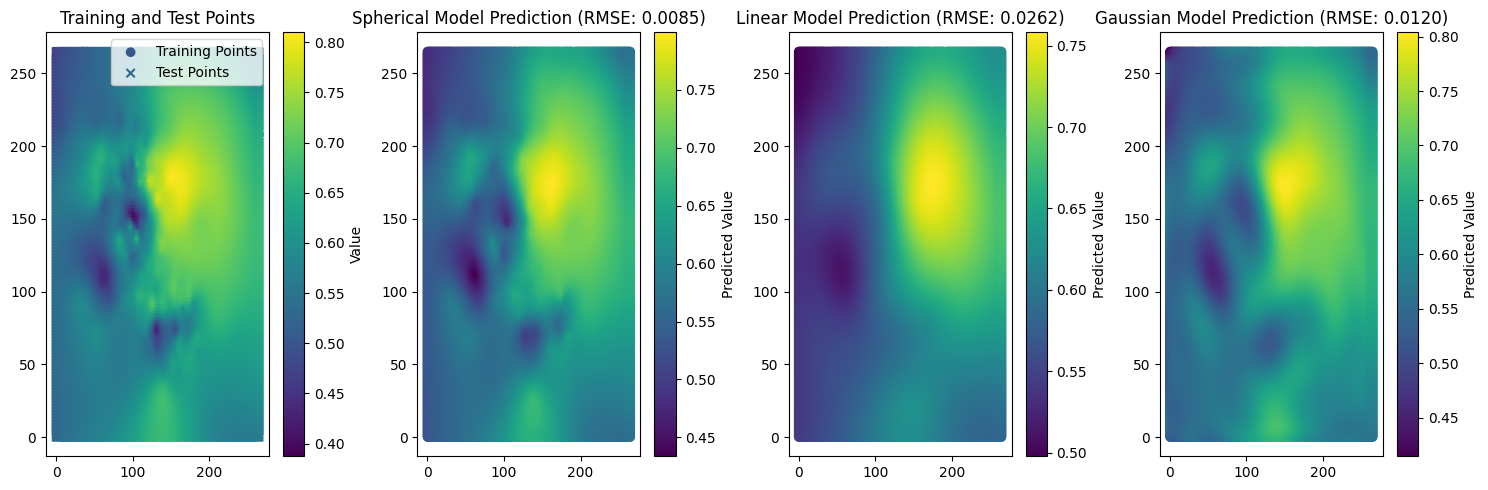

In [18]:
#Compare the differences in ordinary kriging differences

ok_spherical = OrdinaryKriging(X_train[:, 0], X_train[:, 1], y_train, variogram_model='spherical')

ok_linear = OrdinaryKriging(X_train[:, 0], X_train[:, 1], y_train, variogram_model='linear')

ok_gaussian = OrdinaryKriging(X_train[:, 0], X_train[:, 1], y_train, variogram_model='gaussian')

def calculate_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

z_spherical, _ = ok_spherical.execute('points', X_test[:, 0], X_test[:, 1])
z_linear, _ = ok_linear.execute('points', X_test[:, 0], X_test[:, 1])
z_gaussian, _ = ok_gaussian.execute('points', X_test[:, 0], X_test[:, 1])

#calculate RMSE
rmse_spherical = calculate_rmse(y_test, z_spherical)
rmse_linear = calculate_rmse(y_test, z_linear)
rmse_gaussian = calculate_rmse(y_test, z_gaussian)

print(f"Spherical model RMSE: {rmse_spherical}")
print(f"Linear model RMSE: {rmse_linear}")
print(f"Gaussian model RMSE: {rmse_gaussian}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', label='Training Points')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='x', label='Test Points')
plt.colorbar(label='Value')
plt.title('Training and Test Points')
plt.legend()

plt.subplot(1, 4, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=z_spherical, cmap='viridis')
plt.colorbar(label='Predicted Value')
plt.title(f'Spherical Model Prediction (RMSE: {rmse_spherical:.4f})')

plt.subplot(1, 4, 3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=z_linear, cmap='viridis')
plt.colorbar(label='Predicted Value')
plt.title(f'Linear Model Prediction (RMSE: {rmse_linear:.4f})')

plt.subplot(1, 4, 4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=z_gaussian, cmap='viridis')
plt.colorbar(label='Predicted Value')
plt.title(f'Gaussian Model Prediction (RMSE: {rmse_gaussian:.4f})')

plt.tight_layout()
plt.show()

#select the spherical model

In [19]:
#Define a function to draw a more advanced 3D diagram

def ordinary_kriging_choice(param):  
  whatever =  dic_list_F1_target.copy()

  sample_ratio = 0.01  
  np.random.seed(0)  

  coordinates = [(d['x'], d['y']) for d in whatever  ]

  sample_indices = np.random.choice(len(coordinates), int(sample_ratio * len(coordinates)), replace=False)
  sample_coordinates = [coordinates[i] for i in sample_indices]

  train_data = [d for d in whatever if (d['x'], d['y']) in sample_coordinates]
  test_data = [d for d in whatever if (d['x'], d['y']) not in sample_coordinates]

  for d in train_data:
    d['type'] = 'sample'

  X_train = np.array([[d['x'], d['y']] for d in train_data], dtype=float)
  y_train = np.array([d['aij'] for d in train_data], dtype=float)
  X_test = np.array([[d['x'], d['y']] for d in test_data], dtype=float)
  y_test = np.array([d['aij'] for d in test_data], dtype=float)

  ok = OrdinaryKriging(
    X_train[:, 0], X_train[:, 1], y_train,
    variogram_model= param
  )

  z, _ = ok.execute('points', X_test[:, 0], X_test[:, 1])

  for i, idx in enumerate([i for i in range(len(whatever)) if (whatever[i]['x'], whatever[i]['y']) not in sample_coordinates]):
      whatever[idx]['aij'] = z[i]
      whatever[idx]['type'] = 'interpolated'

  y_pred = z.flatten()

  grid_x, grid_y = np.mgrid[0:266, 0:266]
  grid_z = np.zeros((266, 266))
  grid_errors = np.zeros((266, 266))

  for d in whatever:
    grid_z[int(d['x']), int(d['y'])] = d['aij']

  errors = np.abs(y_test - y_pred) 

  grid_errors = np.zeros((266, 266))

  for i, d in enumerate(test_data):
    grid_errors[int(d['x']), int(d['y'])] = errors[i]

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  surf1 = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', linewidth=0, antialiased=False, alpha=0.7)
  ax.set_title('Predicted Values and Errors')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Value')

  surf2 = ax.plot_surface(grid_x,grid_y, grid_errors, cmap='Reds', linewidth=0, antialiased=False, alpha=0.5)

  fig.colorbar(surf1, shrink=0.5, aspect=5, label='Predicted Value')
  fig.colorbar(surf2, shrink=0.5, aspect=5, label='Error')

  plt.show()


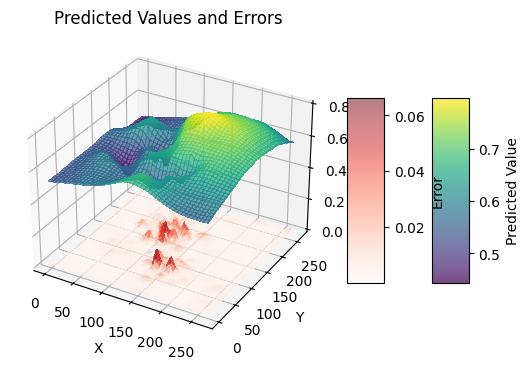

In [20]:
#When the parameter is spherical
ordinary_kriging_choice('spherical')

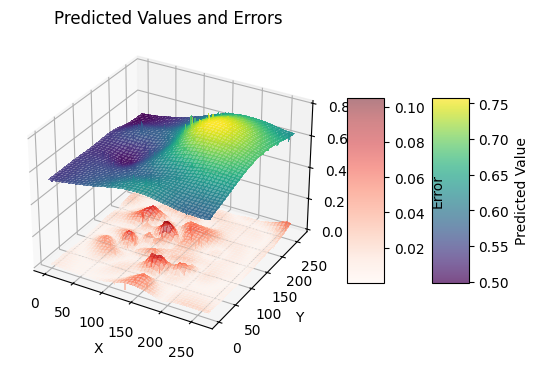

In [21]:
#When the parameter is linear
ordinary_kriging_choice('linear')

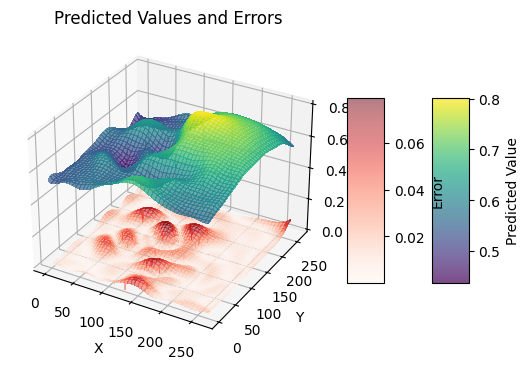

In [22]:
#When the parameter is gaussian
ordinary_kriging_choice('gaussian')

In [23]:
# Perform normal spherical kriging interpolation

dic_list_F1_target_estimated = dic_list_F1_target.copy()

ok = OrdinaryKriging(
    X_train[:, 0], X_train[:, 1], y_train,
    variogram_model='spherical'
)

z, ss = ok.execute('points', X_test[:, 0], X_test[:, 1])

for i, idx in enumerate([i for i in range(len(dic_list_F1_target_estimated)) if (dic_list_F1_target_estimated[i]['x'], dic_list_F1_target_estimated[i]['y']) not in sample_coordinates]):
    dic_list_F1_target_estimated[idx]['aij'] = z[i]
    dic_list_F1_target_estimated[idx]['type'] = 'interpolated'

df_interpolated = pd.DataFrame(dic_list_F1_target_estimated)

print(dic_list_F1_target_estimated[:5])  

print(df_interpolated.head())

# df_interpolated.to_csv('interpolated_output.csv', index=False)

[{'aij': 0.5327011450751731, 'x': 0, 'y': 0, 'type': 'interpolated'}, {'aij': 0.5320699051098319, 'x': 0, 'y': 1, 'type': 'interpolated'}, {'aij': 0.5315487795113336, 'x': 0, 'y': 2, 'type': 'interpolated'}, {'aij': 0.5311379821228315, 'x': 0, 'y': 3, 'type': 'interpolated'}, {'aij': 0.5308536885277562, 'x': 0, 'y': 4, 'type': 'interpolated'}]
        aij  x  y          type
0  0.532701  0  0  interpolated
1  0.532070  0  1  interpolated
2  0.531549  0  2  interpolated
3  0.531138  0  3  interpolated
4  0.530854  0  4  interpolated


In [24]:
y_pred = z.flatten()
y_pred

masked_array(data=[0.5327011450751731, 0.5320699051098319,
                   0.5315487795113336, ..., 0.5750304794824899,
                   0.5740373504327976, 0.5731737014106587],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

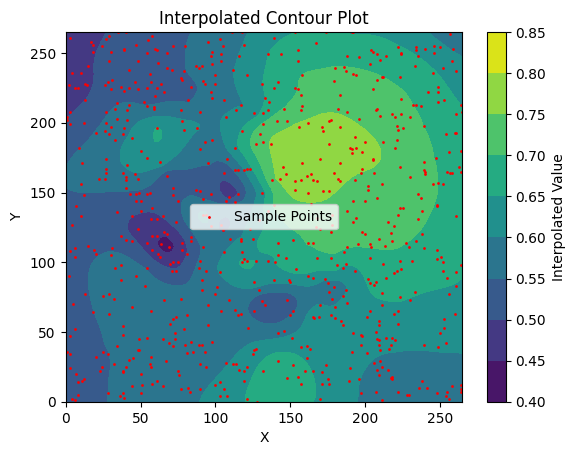

In [ ]:
#Contour plot
grid_x, grid_y = np.mgrid[0:266, 0:266]
grid_z = np.zeros((266, 266))

for d in dic_list_F1_target_estimated:
    grid_z[int(d['x']), int(d['y'])] = d['aij']

contour = plt.contourf(grid_x, grid_y, grid_z, cmap='viridis')
plt.colorbar(contour, label='Interpolated Value')
plt.scatter(X_train[:, 0], X_train[:, 1], c='red', marker='o', label='Sample Points',s = 1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolated Contour Plot')
plt.legend()
plt.show()

In [26]:
interpolated_output = pd.read_csv("D:/桌面/interpolated_output.csv")
interpolated_output.head(5)

,aij,x,y,type
0,0.528475,0,0,interpolated
1,0.529466,0,1,interpolated
2,0.530332,0,2,interpolated
3,0.548320,0,3,interpolated
4,0.531195,0,4,interpolated


   sample_ratio       mse
0        0.0001  0.002567
1        0.0003  0.001635
2        0.0005  0.001649
3        0.0010  0.001361
4        0.0030  0.000870
5        0.0050  0.000658
6        0.0200  0.000288
7        0.0500  0.000135
8        0.0800  0.000081


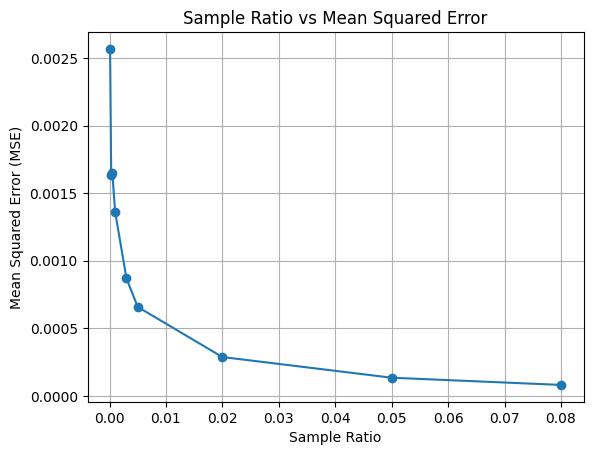

In [27]:
# Vary the sample size to explore the relationship between the sample size and the estimation error

sample_ratios = [0.0001,0.0003,0.0005,0.001,0.003,0.005,0.02,0.05,0.08]

results = []

for ratio in sample_ratios:
    np.random.seed(0) 
    sample_indices = np.random.choice(len(coordinates), int(ratio * len(coordinates)), replace=False)
    sample_coordinates = [coordinates[i] for i in sample_indices]

    train_data = [d for d in dic_list_F1_target if (d['x'], d['y']) in sample_coordinates]
    test_data = [d for d in dic_list_F1_target if (d['x'], d['y']) not in sample_coordinates]

    for d in train_data:
        d['type'] = 'sample'

    X_train = np.array([[d['x'], d['y']] for d in train_data], dtype=float)
    y_train = np.array([d['aij'] for d in train_data], dtype=float)
    X_test = np.array([[d['x'], d['y']] for d in test_data], dtype=float)
    y_true = np.array([d['aij'] for d in test_data], dtype=float)

    ok = OrdinaryKriging(
        X_train[:, 0], X_train[:, 1], y_train,
        variogram_model='linear'
    )

    z, ss = ok.execute('points', X_test[:, 0], X_test[:, 1])
    y_pred = z.flatten()

    mse = mean_squared_error(y_true, y_pred)

    results.append({'sample_ratio': ratio, 'mse': mse})

results_df = pd.DataFrame(results)

print(results_df)

plt.plot(results_df['sample_ratio'], results_df['mse'], marker='o', linestyle='-')
plt.xlabel('Sample Ratio')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Sample Ratio vs Mean Squared Error')
plt.grid(True)
plt.show()

Question 2

In [28]:
F1_collaborative_variable1 = pd.read_csv("D:/ShuweiCup/Attachment 1/F1_collaborative_variable1_output.csv")
F1_collaborative_variable2 = pd.read_csv("D:/ShuweiCup/Attachment 1/F1_collaborative_variable2_output.csv")
F1_collaborative_variable3 = pd.read_csv("D:/ShuweiCup/Attachment 1/F1_collaborative_variable3_output.csv")
F1_collaborative_variable4 = pd.read_csv("D:/ShuweiCup/Attachment 1/F1_collaborative_variable4_output.csv")

dic_list_F1_v1 =  convert_df_to_dict_list(F1_collaborative_variable1)
dic_list_F1_v2 =  convert_df_to_dict_list(F1_collaborative_variable2)
dic_list_F1_v3 =  convert_df_to_dict_list(F1_collaborative_variable3)
dic_list_F1_v4 =  convert_df_to_dict_list(F1_collaborative_variable4)

In [29]:
dic_df_F1_v1 = pd.DataFrame(dic_list_F1_v1)
dic_df_F1_v2 = pd.DataFrame(dic_list_F1_v2)
dic_df_F1_v3 = pd.DataFrame(dic_list_F1_v3)
dic_df_F1_v4 = pd.DataFrame(dic_list_F1_v4)

In [30]:
dic_df_F1_v1

,aij,x,y,type
0,373.0228,0,0,original
1,372.1023,0,1,original
2,371.1602,0,2,original
3,370.1951,0,3,original
4,369.2138,0,4,original
...,...,...,...,...
70751,1471.7654,265,261,original
70752,1458.5519,265,262,original
70753,1445.3789,265,263,original
70754,1432.2629,265,264,original


In [31]:
#Bivariate global Moran index

def create_spatial_weights(df):
    coordinates = [(d['x'], d['y']) for d in df]
    w = lp.weights.DistanceBand.from_array(coordinates, threshold=1.5)
    return w

w = create_spatial_weights(dic_list_F1_target)

def calculate_bivariate_moran(target, collaborative_variable, w):

    target_flat = target.values.flatten()
    collaborative_variable_flat = collaborative_variable.values.flatten()

    moran = Moran_BV(target_flat, collaborative_variable_flat, w)
    return moran.I, moran.p_sim

morans = []
name_list =  [F1_collaborative_variable1,F1_collaborative_variable2,F1_collaborative_variable3,F1_collaborative_variable4]
for var in name_list:
    moran_I, p_value = calculate_bivariate_moran(F1_target_variable, var, w)
    morans.append((moran_I, p_value))

moran_I_list = []

for i, (moran_I, p_value) in enumerate(morans):
    print(f"F1 Collaborative Variable {i + 1} - Bivariate Moran's I: {moran_I}, p-value: {p_value}")
    moran_I_list.append(moran_I)

# Choose the largest bivariate Moran index
best_index = np.argmax([moran_I for moran_I, _ in morans])
best_moran_I, best_p_value = morans[best_index]
print(f"F1 Best Collaborative Variable: {best_index + 1} - Bivariate Moran's I: {best_moran_I}, p-value: {best_p_value}")


F1 Collaborative Variable 1 - Bivariate Moran's I: 0.764336170463134, p-value: 0.001
F1 Collaborative Variable 2 - Bivariate Moran's I: 0.04753920857479687, p-value: 0.001
F1 Collaborative Variable 3 - Bivariate Moran's I: 0.15640583096762012, p-value: 0.001
F1 Collaborative Variable 4 - Bivariate Moran's I: 0.3428830246170835, p-value: 0.001
F1 Best Collaborative Variable: 1 - Bivariate Moran's I: 0.764336170463134, p-value: 0.001


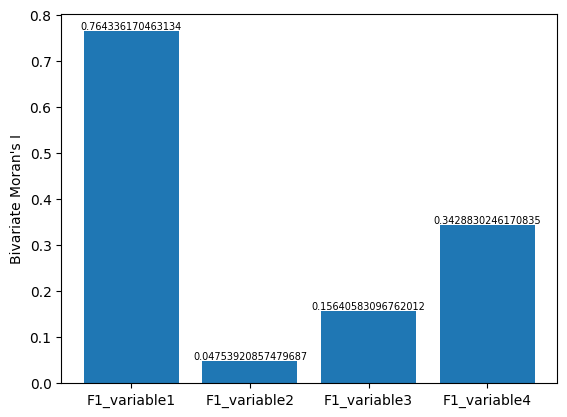

In [32]:
name_list_1 = ['F1_variable1','F1_variable2','F1_variable3','F1_variable4']

plt.bar(name_list_1, moran_I_list)
plt.ylabel("Bivariate Moran's I")
for i, v in enumerate(moran_I_list):
    plt.text(i, v, str(v), ha='center', va='bottom',fontsize = 7)
plt.show()

#choose F1_variable_1，F1_variable_4

In [33]:
moran_I_list

[0.764336170463134,
 0.04753920857479687,
 0.15640583096762012,
 0.3428830246170835]

Question 3

In [34]:
dic_df_F1_v1.head(10)

,aij,x,y,type
0,373.0228,0,0,original
1,372.1023,0,1,original
2,371.1602,0,2,original
3,370.1951,0,3,original
4,369.2138,0,4,original
5,368.2181,0,5,original
6,367.2090,0,6,original
7,366.1871,0,7,original
8,365.1606,0,8,original
9,364.1306,0,9,original


In [35]:
dic_df_F1_v4.head(10)

,aij,x,y,type
0,0.3218,0,0,original
1,0.3220,0,1,original
2,0.3222,0,2,original
3,0.3224,0,3,original
4,0.3225,0,4,original
5,0.3227,0,5,original
6,0.3229,0,6,original
7,0.3230,0,7,original
8,0.3232,0,8,original
9,0.3234,0,9,original


In [36]:
#Collaborative kriging algorithm

sample_ratio = 0.05 
np.random.seed(0)

coordinates = [(d['x'], d['y']) for d in dic_list_F1_target]

sample_indices = np.random.choice(len(coordinates), int(sample_ratio * len(coordinates)), replace=False)
sample_coordinates = [coordinates[i] for i in sample_indices]

train_data = [d for d in dic_list_F1_target if (d['x'], d['y']) in sample_coordinates]
test_data = [d for d in dic_list_F1_target if (d['x'], d['y']) not in sample_coordinates]

for d in train_data:
    d['type'] = 'sample'

X_train = np.array([[d['x'], d['y']] for d in train_data], dtype=float) #3537
y_train = np.array([d['aij'] for d in train_data], dtype=float) #3537
X_test = np.array([[d['x'], d['y']] for d in test_data], dtype=float) #67219
y_test = np.array([d['aij'] for d in test_data], dtype=float) #67219


In [37]:
#Extract covariables
F1_collaborative_variable1_values_sampled = dic_df_F1_v1['aij'].iloc[sample_indices].values
F1_collaborative_variable4_values_sampled = dic_df_F1_v4['aij'].iloc[sample_indices].values

# Get unsampled data
F1_collaborative_variable1_values_unsampled = dic_df_F1_v1['aij'].iloc[list(set(range(len(coordinates))) - set(sample_indices))].values
F1_collaborative_variable4_values_unsampled = dic_df_F1_v4['aij'].iloc[list(set(range(len(coordinates))) - set(sample_indices))].values

# Define a covariance model
model_target = gs.Exponential(dim=2, var=1.0, len_scale=10.0)
model_co_var1 = gs.Exponential(dim=2, var=0.5, len_scale=8.0)
model_co_var4 = gs.Exponential(dim=2, var=0.3, len_scale=6.0)
cross_corr_1 = moran_I_list[0] + 0.1 
cross_corr_4 = moran_I_list[3] - 0.1

In [38]:
# Construct a joint covariance matrix
n_sampled = len(sample_coordinates)
n_unsampled = len(X_test)
total_vars = 3

distances = np.linalg.norm(X_train[:, np.newaxis] - X_train[np.newaxis, :], axis=2)

print(distances.shape) 

joint_cov_matrix = np.zeros((total_vars * n_sampled, total_vars * n_sampled))
joint_cov_matrix[:n_sampled, :n_sampled] = model_target.covariance(distances)
joint_cov_matrix[:n_sampled, n_sampled:2*n_sampled] = cross_corr_1 * model_target.covariance(distances)
joint_cov_matrix[:n_sampled, 2*n_sampled:] = cross_corr_4 * model_target.covariance(distances)
joint_cov_matrix[n_sampled:2*n_sampled, :n_sampled] = cross_corr_1 * model_target.covariance(distances)
joint_cov_matrix[n_sampled:2*n_sampled, n_sampled:2*n_sampled] = model_co_var1.covariance(distances)
joint_cov_matrix[n_sampled:2*n_sampled, 2*n_sampled:] = cross_corr_1 * cross_corr_4 * model_target.covariance(distances)
joint_cov_matrix[2*n_sampled:, :n_sampled] = cross_corr_4 * model_target.covariance(distances)
joint_cov_matrix[2*n_sampled:, n_sampled:2*n_sampled] = cross_corr_1 * cross_corr_4 * model_target.covariance(distances)
joint_cov_matrix[2*n_sampled:, 2*n_sampled:] = model_co_var4.covariance(distances)

(3537, 3537)


In [39]:
# Construct covariance vectors
cov_vector = np.zeros((total_vars * n_sampled, n_unsampled))
for i in range(n_unsampled):
    h = np.linalg.norm(X_train - X_test[i], axis=1)
    cov_vector[:n_sampled, i] = model_target.covariance(h)

    cov_vector[n_sampled:2*n_sampled, i] = cross_corr_1 * model_target.covariance(h)

    cov_vector[2*n_sampled:, i] = cross_corr_4 * model_target.covariance(h)

cond_values = np.hstack([y_train, F1_collaborative_variable1_values_sampled, F1_collaborative_variable4_values_sampled])

weights = np.linalg.solve(joint_cov_matrix, cov_vector)

predicted_values = np.dot(weights.T, cond_values)

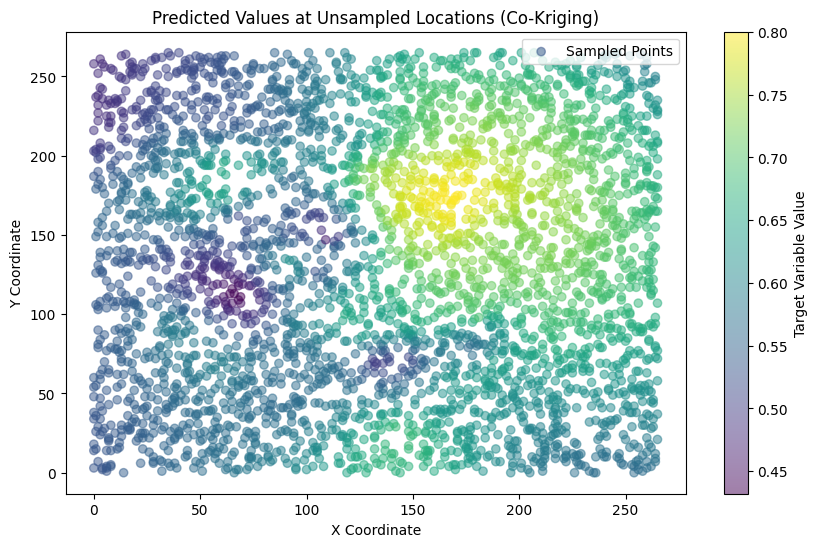

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', label="Sampled Points", alpha=0.5)
plt.colorbar(label="Target Variable Value")
plt.title("Predicted Values at Unsampled Locations (Co-Kriging)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

In [41]:
dic_list_F1_target_estimated_ck = dic_list_F1_target.copy()

for i, idx in enumerate([i for i in range(len(dic_list_F1_target_estimated_ck)) if (dic_list_F1_target_estimated_ck[i]['x'], dic_list_F1_target_estimated[i]['y']) not in sample_coordinates]):
    dic_list_F1_target_estimated[idx]['aij'] = predicted_values[i]
    dic_list_F1_target_estimated[idx]['type'] = 'interpolated'

df_interpolated_ck = pd.DataFrame(dic_list_F1_target_estimated_ck)

print(dic_list_F1_target_estimated_ck[:5])  

print(df_interpolated_ck.head())

df_interpolated_ck.to_csv('interpolated_ck_output.csv', index=False)

[{'aij': 0.43931805571731414, 'x': 0, 'y': 0, 'type': 'interpolated'}, {'aij': 0.468896393571729, 'x': 0, 'y': 1, 'type': 'interpolated'}, {'aij': 0.49937357943150135, 'x': 0, 'y': 2, 'type': 'interpolated'}, {'aij': 0.5311379821228315, 'x': 0, 'y': 3, 'type': 'sample'}, {'aij': 0.5208699532077247, 'x': 0, 'y': 4, 'type': 'interpolated'}]
        aij  x  y          type
0  0.439318  0  0  interpolated
1  0.468896  0  1  interpolated
2  0.499374  0  2  interpolated
3  0.531138  0  3        sample
4  0.520870  0  4  interpolated


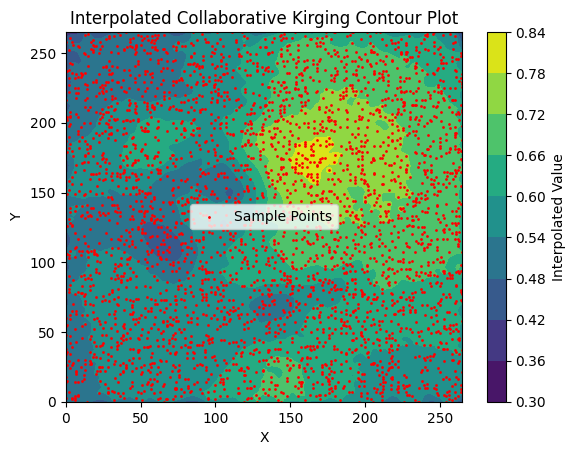

In [ ]:
#Contour plot
grid_x, grid_y = np.mgrid[0:266, 0:266]
grid_z = np.zeros((266, 266))

for d in dic_list_F1_target_estimated_ck:
    grid_z[int(d['x']), int(d['y'])] = d['aij']

contour = plt.contourf(grid_x, grid_y, grid_z, cmap='viridis')
plt.colorbar(contour, label='Interpolated Value')
plt.scatter(X_train[:, 0], X_train[:, 1], c='red', marker='o', label='Sample Points',s = 1) #选择训练集的采样点
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolated Collaborative Kirging Contour Plot')
plt.legend()
plt.show()

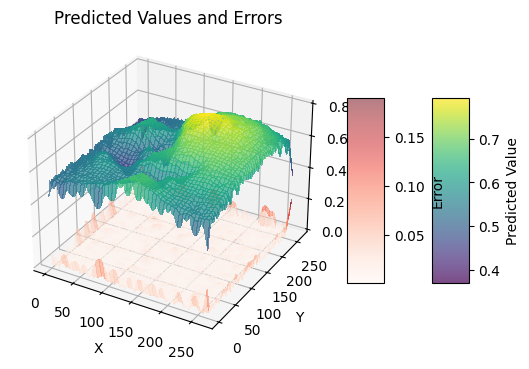

In [43]:
grid_x, grid_y = np.mgrid[0:266, 0:266]
grid_z = np.zeros((266, 266))
grid_errors = np.zeros((266, 266))

for d in dic_list_F1_target_estimated_ck:
    grid_z[int(d['x']), int(d['y'])] = d['aij']

errors = np.abs(predicted_values - y_test)

for i, d in enumerate(test_data):
    grid_errors[int(d['x']), int(d['y'])] = errors[i]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf1 = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', linewidth=0, antialiased=False, alpha=0.7)
ax.set_title('Predicted Values and Errors')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')

surf2 = ax.plot_surface(grid_x,grid_y, grid_errors, cmap='Reds', linewidth=0, antialiased=False, alpha=0.5)

fig.colorbar(surf1, shrink=0.5, aspect=5, label='Predicted Value')
fig.colorbar(surf2, shrink=0.5, aspect=5, label='Error')

plt.show()

In [44]:
mean_squared_error(predicted_values,y_test)

0.0001667709300248784

    sample_ratio           mse
0         0.0001  3.350565e-01
1         0.0003  2.846777e-01
2         0.0005  2.394522e-01
3         0.0010  1.549424e-01
4         0.0030  5.057102e-02
5         0.0050  2.340239e-02
6         0.0200  7.187912e-04
7         0.0300  1.793983e-04
8         0.0400  4.412765e-05
9         0.0500  0.000000e+00
10        0.0600  4.321672e-21
11        0.0700  3.793216e-01
12        0.0800  3.792512e-01


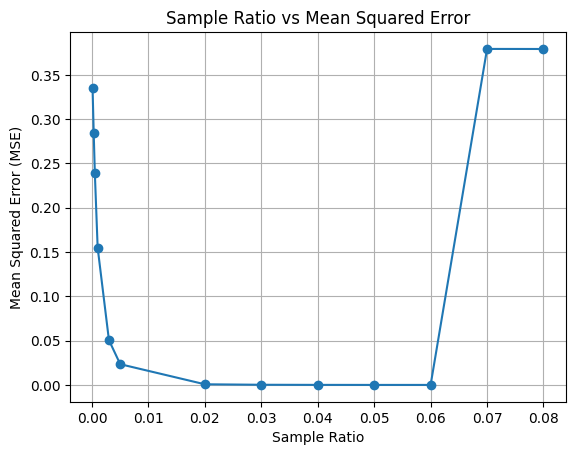

In [45]:
#Vary the sample size to explore the relationship between the sample size and the estimation error

sample_ratios = [0.0001,0.0003,0.0005,0.001,0.003,0.005,0.02,0.03,0.04,0.05,0.06,0.07,0.08]

results = []

for ratio in sample_ratios:
  np.random.seed(0)  

  coordinates = [(d['x'], d['y']) for d in dic_list_F1_target]

  sample_indices = np.random.choice(len(coordinates), int(ratio * len(coordinates)), replace=False)
  sample_coordinates = [coordinates[i] for i in sample_indices]

  train_data = [d for d in dic_list_F1_target if (d['x'], d['y']) in sample_coordinates]
  test_data = [d for d in dic_list_F1_target if (d['x'], d['y']) not in sample_coordinates]

  for d in train_data:
    d['type'] = 'sample'

  X_train = np.array([[d['x'], d['y']] for d in train_data], dtype=float) #3537
  y_train = np.array([d['aij'] for d in train_data], dtype=float) #3537
  X_test = np.array([[d['x'], d['y']] for d in test_data], dtype=float) #67219
  y_test = np.array([d['aij'] for d in test_data], dtype=float) #67219

  F1_collaborative_variable1_values_sampled = dic_df_F1_v1['aij'].iloc[sample_indices].values
  F1_collaborative_variable4_values_sampled = dic_df_F1_v4['aij'].iloc[sample_indices].values

  F1_collaborative_variable1_values_unsampled = dic_df_F1_v1['aij'].iloc[list(set(range(len(coordinates))) - set(sample_indices))].values
  F1_collaborative_variable4_values_unsampled = dic_df_F1_v4['aij'].iloc[list(set(range(len(coordinates))) - set(sample_indices))].values

  model_target = gs.Exponential(dim=2, var=1.0, len_scale=10.0)
  model_co_var1 = gs.Exponential(dim=2, var=0.5, len_scale=8.0)
  model_co_var4 = gs.Exponential(dim=2, var=0.3, len_scale=6.0)
  cross_corr_1 = moran_I_list[0] + 0.1 
  cross_corr_4 = moran_I_list[3] - 0.1

  n_sampled = len(sample_coordinates)
  n_unsampled = len(X_test)
  total_vars = 3 

  distances = np.linalg.norm(X_train[:, np.newaxis] - X_train[np.newaxis, :], axis=2)

  joint_cov_matrix = np.zeros((total_vars * n_sampled, total_vars * n_sampled))
  joint_cov_matrix[:n_sampled, :n_sampled] = model_target.covariance(distances)
  joint_cov_matrix[:n_sampled, n_sampled:2*n_sampled] = cross_corr_1 * model_target.covariance(distances)
  joint_cov_matrix[:n_sampled, 2*n_sampled:] = cross_corr_4 * model_target.covariance(distances)
  joint_cov_matrix[n_sampled:2*n_sampled, :n_sampled] = cross_corr_1 * model_target.covariance(distances)
  joint_cov_matrix[n_sampled:2*n_sampled, n_sampled:2*n_sampled] = model_co_var1.covariance(distances)
  joint_cov_matrix[n_sampled:2*n_sampled, 2*n_sampled:] = cross_corr_1 * cross_corr_4 * model_target.covariance(distances)
  joint_cov_matrix[2*n_sampled:, :n_sampled] = cross_corr_4 * model_target.covariance(distances)
  joint_cov_matrix[2*n_sampled:, n_sampled:2*n_sampled] = cross_corr_1 * cross_corr_4 * model_target.covariance(distances)
  joint_cov_matrix[2*n_sampled:, 2*n_sampled:] = model_co_var4.covariance(distances)

  cov_vector = np.zeros((total_vars * n_sampled, n_unsampled))
  for i in range(n_unsampled):
    h = np.linalg.norm(X_train - X_test[i], axis=1)
    cov_vector[:n_sampled, i] = model_target.covariance(h)

    cov_vector[n_sampled:2*n_sampled, i] = cross_corr_1 * model_target.covariance(h)

    cov_vector[2*n_sampled:, i] = cross_corr_4 * model_target.covariance(h)

  cond_values = np.hstack([y_train, F1_collaborative_variable1_values_sampled, F1_collaborative_variable4_values_sampled])

  weights = np.linalg.solve(joint_cov_matrix, cov_vector)

  predicted_values = np.dot(weights.T, cond_values)

  mse = mean_squared_error(predicted_values,y_test)

  results.append({'sample_ratio': ratio, 'mse': mse})

results_df = pd.DataFrame(results)

print(results_df)

plt.plot(results_df['sample_ratio'], results_df['mse'], marker='o', linestyle='-')
plt.xlabel('Sample Ratio')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Sample Ratio vs Mean Squared Error')
plt.grid(True)
plt.show()

#Overfitted

In [46]:
#Choose at least two methods

#Deep Kriging algorithm
cor1 = dic_df_F1_v1.copy()
cor2 = dic_df_F1_v4.copy()
target = dic_df_F1_target.copy()

cor1.columns = ['z1', 'x', 'y','type']
cor2.columns = ['z2', 'x', 'y','type']
target.columns = ['zt', 'x', 'y','type']

data = cor1.merge(cor2, on=['x', 'y']).merge(target, on=['x', 'y'])

X = data[['x', 'y', 'z1', 'z2']].values 
y = data['zt'].values  

In [47]:
sample_ratios = [0.001, 0.005, 0.01, 0.03, 0.05, 0.07]

mse_values = []

fig = plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

c:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample rate: 0.001, MSE: 0.00020389449049908166


c:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Sample rate: 0.005, MSE: 0.00016941575778088426


c:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sample rate: 0.01, MSE: 5.2687137067924216e-05


c:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Sample rate: 0.03, MSE: 0.00014788386493474952


c:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Sample rate: 0.05, MSE: 6.200470877536115e-05


c:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
Sample rate: 0.07, MSE: 7.296128188912297e-05


<Figure size 640x480 with 0 Axes>

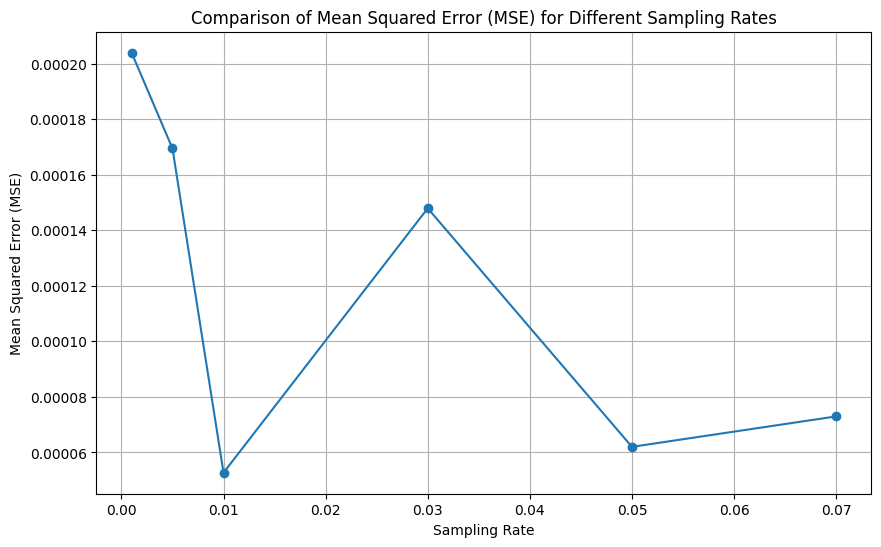

{'0.001': 0.00020389449049908166, '0.005': 0.00016941575778088426, '0.01': 5.2687137067924216e-05, '0.03': 0.00014788386493474952, '0.05': 6.200470877536115e-05, '0.07': 7.296128188912297e-05}


In [48]:
for i, sample_ratio in enumerate(sample_ratios):
    np.random.seed(0)  
    sample_indices = np.random.choice(len(X), int(sample_ratio * len(X)), replace=False)
    X_train = X[sample_indices]
    y_train = y[sample_indices]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(4,)),  
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

    y_train_pred = model.predict(X_train_scaled).flatten()

    mse = mean_squared_error(y_train, y_train_pred)
    mse_values.append(mse)
    print(f"Sample rate: {sample_ratio}, MSE: {mse}")

    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    X_grid, Y_grid = np.meshgrid(np.linspace(min(X[:, 0]), max(X[:, 0]), 100), np.linspace(min(X[:, 1]), max(X[:, 1]), 100))
    Z_grid_pred = griddata(X_train[:, :2], y_train_pred, (X_grid, Y_grid), method='cubic')
    surf = ax.plot_surface(X_grid, Y_grid, Z_grid_pred, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, shrink=0.5, aspect=5, label='Value')
    ax.set_title(f'Sampling Rate: {sample_ratio}\nMSE: {mse:.4f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sample_ratios, mse_values, marker='o', linestyle='-')
plt.xlabel('Sampling Rate')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) for Different Sampling Rates')
plt.grid(True)
plt.show()

mse_values_dict = {f'{sr}': mse for sr, mse in zip(sample_ratios, mse_values)}
print(mse_values_dict)

Question 4

In [49]:
F2_collaborative_variable1 = pd.read_csv("D:/ShuweiCup/Attachment 2/F2_collaborative_variable1_output.csv")
F2_collaborative_variable2 = pd.read_csv("D:/ShuweiCup/Attachment 2/F2_collaborative_variable2_output.csv")
F2_collaborative_variable3 = pd.read_csv("D:/ShuweiCup/Attachment 2/F2_collaborative_variable3_output.csv")
F2_collaborative_variable4 = pd.read_csv("D:/ShuweiCup/Attachment 2/F2_collaborative_variable4_output.csv")
F2_target_variable = pd.read_excel("D:/ShuweiCup/Attachment 2/F2_target_variable.xlsx")

In [50]:
len(F2_target_variable)

1000

In [51]:
dic_list_F2_v1 = convert_df_to_dict_list(F2_collaborative_variable1)
dic_list_F2_v2 = convert_df_to_dict_list(F2_collaborative_variable2)
dic_list_F2_v3 = convert_df_to_dict_list(F2_collaborative_variable3)
dic_list_F2_v4 = convert_df_to_dict_list(F2_collaborative_variable4)

In [52]:
dic_df_F2_v1 = pd.DataFrame(dic_list_F2_v1)
dic_df_F2_v2 = pd.DataFrame(dic_list_F2_v2)
dic_df_F2_v3 = pd.DataFrame(dic_list_F2_v3)
dic_df_F2_v4 = pd.DataFrame(dic_list_F2_v4)
dic_df_F2_target = pd.DataFrame(F2_target_variable)

In [53]:
dic_df_F2_target = F2_target_variable[['Target Property','Column Sequence','Row Sequence' ]]
dic_df_F2_target.columns = ['aij', 'x', 'y']
dic_df_F2_target.head(5)

,aij,x,y
0,0.6120,51,20
1,0.6388,144,2
2,0.3913,102,186
3,0.4592,133,237
4,0.6018,264,46


In [54]:
#The target variable has a lower number of rows (1000 rows), while the covariate has 70756 rows. 
# We need to filter out the matching points in the covariate based on the coordinates of the target variable.

def find_corresponding_values(target_df, v_df):
    merged_df = target_df.merge(v_df[['x', 'y', 'aij']], on=['x', 'y'], how='left')
    merged_df.columns = ['aij_target','x','y','aij_variable']
    return merged_df

dic_df_F2_target_with_v1_values = find_corresponding_values(dic_df_F2_target, dic_df_F2_v1)
dic_df_F2_target_with_v2_values = find_corresponding_values(dic_df_F2_target, dic_df_F2_v2)
dic_df_F2_target_with_v3_values = find_corresponding_values(dic_df_F2_target, dic_df_F2_v3)
dic_df_F2_target_with_v4_values = find_corresponding_values(dic_df_F2_target, dic_df_F2_v4)

print(dic_df_F2_target_with_v2_values.head())
print(len(dic_df_F2_target_with_v2_values))

   aij_target    x    y  aij_variable
0      0.6120   51   20        0.9352
1      0.6388  144    2        0.8519
2      0.3913  102  186        0.9373
3      0.4592  133  237        0.8674
4      0.6018  264   46        0.8553
1000


In [55]:
#generate dic_df_Fi_corresponded 

def convert_df_to_corresponded(target_with_v):
  corresponded = target_with_v[['aij_variable','x','y']]
  corresponded = pd.DataFrame(corresponded)
  corresponded.columns = ['aij','x','y']
  return corresponded

dic_df_F2_v1_corresponded = convert_df_to_corresponded(dic_df_F2_target_with_v1_values)
dic_df_F2_v2_corresponded = convert_df_to_corresponded(dic_df_F2_target_with_v2_values)
dic_df_F2_v3_corresponded = convert_df_to_corresponded(dic_df_F2_target_with_v3_values)
dic_df_F2_v4_corresponded = convert_df_to_corresponded(dic_df_F2_target_with_v4_values)

print(dic_df_F2_v2_corresponded.head(5))
print(len(dic_df_F2_v2_corresponded))

      aij    x    y
0  0.9352   51   20
1  0.8519  144    2
2  0.9373  102  186
3  0.8674  133  237
4  0.8553  264   46
1000


In [56]:
#The conversion of dataframe to dictionary facilitates the subsequent calculation of the weight w in the Moran index
dic_list_F2_target = dic_df_F2_target.to_dict(orient='records')
dic_list_F2_target

[{'aij': 0.612, 'x': 51, 'y': 20},
 {'aij': 0.6388, 'x': 144, 'y': 2},
 {'aij': 0.3913, 'x': 102, 'y': 186},
 {'aij': 0.4592, 'x': 133, 'y': 237},
 {'aij': 0.6018, 'x': 264, 'y': 46},
 {'aij': 0.6107, 'x': 79, 'y': 67},
 {'aij': 0.658, 'x': 154, 'y': 147},
 {'aij': 0.6608, 'x': 146, 'y': 128},
 {'aij': 0.6661, 'x': 174, 'y': 146},
 {'aij': 0.407, 'x': 103, 'y': 264},
 {'aij': 0.514, 'x': 162, 'y': 72},
 {'aij': 0.4521, 'x': 131, 'y': 239},
 {'aij': 0.6476, 'x': 159, 'y': 154},
 {'aij': 0.529, 'x': 256, 'y': 227},
 {'aij': 0.5356, 'x': 116, 'y': 199},
 {'aij': 0.6377, 'x': 34, 'y': 82},
 {'aij': 0.5206, 'x': 152, 'y': 206},
 {'aij': 0.5775, 'x': 120, 'y': 156},
 {'aij': 0.6513, 'x': 170, 'y': 101},
 {'aij': 0.4525, 'x': 113, 'y': 232},
 {'aij': 0.509, 'x': 197, 'y': 229},
 {'aij': 0.6354, 'x': 12, 'y': 123},
 {'aij': 0.5054, 'x': 265, 'y': 242},
 {'aij': 0.6908, 'x': 139, 'y': 96},
 {'aij': 0.4847, 'x': 12, 'y': 212},
 {'aij': 0.5879, 'x': 110, 'y': 82},
 {'aij': 0.4637, 'x': 192, 'y': 

In [57]:
#Bivariate global Moran index

def create_spatial_weights(df):
    coordinates = [(d['x'], d['y']) for d in df]
    w = lp.weights.DistanceBand.from_array(coordinates, threshold=1.5)
    return w

w = create_spatial_weights(dic_list_F2_target)

def calculate_bivariate_moran(target, collaborative_variable, w):
    target_flat = target['aij']
    collaborative_variable_flat = collaborative_variable['aij']

    moran = Moran_BV(target_flat, collaborative_variable_flat, w)
    return moran.I, moran.p_sim

morans = []
name_list =  [dic_df_F2_v1_corresponded,dic_df_F2_v2_corresponded,dic_df_F2_v3_corresponded,dic_df_F2_v4_corresponded]
for var in name_list:
    moran_I, p_value = calculate_bivariate_moran(dic_df_F2_target, var, w)
    morans.append((moran_I, p_value))

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING:

c:\python\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 943 disconnected components.
 There are 891 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 98, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 

In [58]:
moran_I_list = []

for i, (moran_I, p_value) in enumerate(morans):
    print(f"F1 Collaborative Variable {i +1} - Bivariate Moran's I: {moran_I}, p-value: {p_value}")
    moran_I_list.append(moran_I)

best_index = np.argmax([moran_I for moran_I, _ in morans])
best_moran_I, best_p_value = morans[best_index]
print(f"F1 Best Collaborative Variable: {best_index + 1} - Bivariate Moran's I: {best_moran_I}, p-value: {best_p_value}")

F1 Collaborative Variable 1 - Bivariate Moran's I: 0.03578333492219562, p-value: 0.001
F1 Collaborative Variable 2 - Bivariate Moran's I: 0.014553719359214918, p-value: 0.094
F1 Collaborative Variable 3 - Bivariate Moran's I: 0.09549946516662179, p-value: 0.001
F1 Collaborative Variable 4 - Bivariate Moran's I: 0.00345589465209971, p-value: 0.373
F1 Best Collaborative Variable: 3 - Bivariate Moran's I: 0.09549946516662179, p-value: 0.001


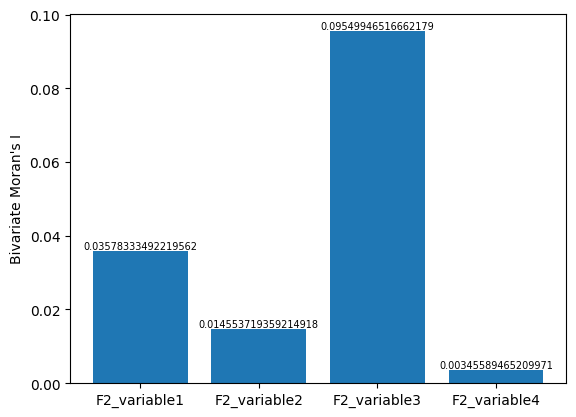

In [59]:
name_list_2 = ['F2_variable1','F2_variable2','F2_variable3','F2_variable4']

plt.bar(name_list_2, moran_I_list)
plt.ylabel("Bivariate Moran's I")
for i, v in enumerate(moran_I_list):
    plt.text(i, v, str(v), ha='center', va='bottom',fontsize = 7)
plt.show()

In [ ]:
# from skgstat import Variogram, OrdinaryKriging

# f2_target.columns = ['x', 'y'] + list(f2_target.columns[2:])

# x = f2_target['x'].values
# y = f2_target['y'].values
# z = f2_target['Target Property'].values

# coordinates = np.column_stack((x, y))

# variogram = Variogram(coordinates, z)

# grid_x, grid_y = np.mgrid[0:266, 0:266]
# grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# kriging = OrdinaryKriging(variogram)
# kriged_values = kriging.transform(grid_points)

# kriged_grid = kriged_values.reshape((266, 266))

# output_file = r'C:\Users\86185\Desktop\F2_target_interpolated.csv'
# np.savetxt(output_file, kriged_grid, delimiter=',')

# print(kriged_grid[:10, :10])

In [61]:
F2_target_interpolated = pd.read_csv('D:/桌面/F2_target_interpolated.csv',skiprows=0,header=None) #The first row cannot be considered a listing

In [62]:
dic_list_F2_target_interpolated = convert_df_to_dict_list(F2_target_interpolated)
dic_df_F2_target_interpolated = pd.DataFrame(dic_list_F2_target_interpolated)

In [63]:
#Bivariate global Moran index

def create_spatial_weights(df):
    coordinates = [(d['x'], d['y']) for d in df]
    w = lp.weights.DistanceBand.from_array(coordinates, threshold=1.5)
    return w

w = create_spatial_weights(dic_list_F2_target_interpolated)

def calculate_bivariate_moran(target, collaborative_variable, w):
    target_flat = target['aij']
    collaborative_variable_flat = collaborative_variable['aij']

    moran = Moran_BV(target_flat, collaborative_variable_flat, w)
    return moran.I, moran.p_sim

morans = []
name_list =  [dic_df_F2_v1,dic_df_F2_v2,dic_df_F2_v3,dic_df_F2_v4]
for var in name_list:
    moran_I, p_value = calculate_bivariate_moran(dic_df_F2_target_interpolated, var, w)
    morans.append((moran_I, p_value))

In [64]:
moran_I_list = []

for i, (moran_I, p_value) in enumerate(morans):
    print(f"F1 Collaborative Variable {i +1} - Bivariate Moran's I: {moran_I}, p-value: {p_value}")
    moran_I_list.append(moran_I)

best_index = np.argmax([moran_I for moran_I, _ in morans])
best_moran_I, best_p_value = morans[best_index]
print(f"F1 Best Collaborative Variable: {best_index + 1} - Bivariate Moran's I: {best_moran_I}, p-value: {best_p_value}")

F1 Collaborative Variable 1 - Bivariate Moran's I: 0.1858685943206492, p-value: 0.001
F1 Collaborative Variable 2 - Bivariate Moran's I: 0.2863802237635277, p-value: 0.001
F1 Collaborative Variable 3 - Bivariate Moran's I: 0.7210628059204383, p-value: 0.001
F1 Collaborative Variable 4 - Bivariate Moran's I: 0.006682090649287905, p-value: 0.052
F1 Best Collaborative Variable: 3 - Bivariate Moran's I: 0.7210628059204383, p-value: 0.001


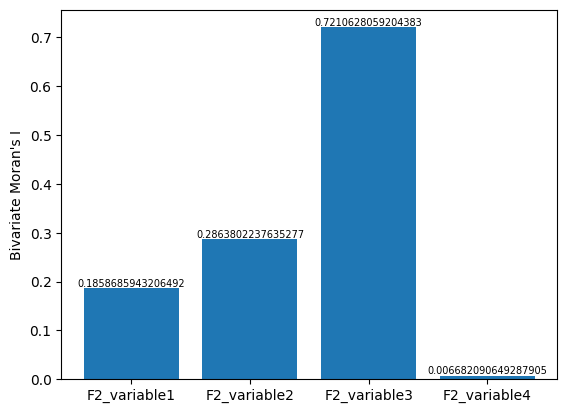

In [65]:
name_list_3 = ['F2_variable1','F2_variable2','F2_variable3','F2_variable4']

plt.bar(name_list_3, moran_I_list)
plt.ylabel("Bivariate Moran's I")
for i, v in enumerate(moran_I_list):
    plt.text(i, v, str(v), ha='center', va='bottom',fontsize = 7)
plt.show()

#choose F2 varaible 3

In [ ]:
# #Deep Kriging algorithm

# plt.rcParams['figure.figsize'] = (8, 6)

# file_path_target = r'D:/ShuweiCup/Attachment 2/F2_target_variable.xlsx'
# f2_target = pd.read_excel(file_path_target)

# file_path_covariate3 = r'D:/ShuweiCup/Attachment 2/F2_collaborative_variable3_output.csv'
# df_covariate3 = pd.read_csv(file_path_covariate3)

# df_covariate3.rename(columns={'z': 'zcor3'}, inplace=True)

# f2_target = f2_target.rename(columns={f2_target.columns[0]: 'x', f2_target.columns[1]: 'y', f2_target.columns[4]: 'z'})
# f2_target = f2_target[['x', 'y', 'z']]

# print("F2 target columns:", f2_target.columns)
# print("Covariate 3 columns:", df_covariate3.columns)

# sample_size = 1000
# df_f2_sample = f2_target.iloc[:sample_size].copy()

# df_merged = pd.merge(df_f2_sample, df_covariate3, on=['x', 'y'], how='left')

# print(f"Sample size: {sample_size}")
# print(df_merged.head())
# print(df_merged.describe())
# print(df_merged.isnull().sum())

# df_merged = df_merged.dropna()

# X = df_merged[['x', 'y', 'zcor3']].values
# y = df_merged['z'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
#                     input_shape=(X_train.shape[1],),
#                     kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-1, step=1e-2)),
#                     activation='relu'))
#     model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(BatchNormalization())

#     model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
#                     kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_2', min_value=1e-5, max_value=1e-1, step=1e-2)),
#                     activation='relu'))
#     model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(BatchNormalization())

#     model.add(Dense(1, activation='linear'))  
#     model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])  
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_mse',
#     max_trials=5,
#     executions_per_trial=1, 
#     directory=f'my_dir_{sample_size}',
#     project_name=f'deep_kriging_tuning_{sample_size}'
# )

# tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)  

# best_model = tuner.get_best_models(num_models=1)[0]

# y_pred = best_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# print(f"Sample size: {sample_size}, MSE: {mse}, MAE: {mae}")

# plt.scatter(y_test, y_pred, color='blue')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title(f'DeepKriging Predictions vs Actual Values (Sample Size: {sample_size})')
# plt.savefig(f'C:/Users/86185/Desktop/deep_kriging_{sample_size}.png')
# plt.close()

# grid_size = 266
# total_points = grid_size * grid_size
# remaining_points = total_points - sample_size

# x_coords = np.linspace(0, 265, grid_size)
# y_coords = np.linspace(0, 265, grid_size)
# xx, yy = np.meshgrid(x_coords, y_coords)
# grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# df_grid = pd.DataFrame(grid_points, columns=['x', 'y'])
# df_grid_merged = pd.merge(df_grid, df_covariate3, on=['x', 'y'], how='left')

# print("Grid data merged with covariates:")
# print(df_grid_merged.head())
# print(df_grid_merged.describe())
# print(df_grid_merged.isnull().sum())

# df_grid_merged = df_grid_merged.dropna()

# X_grid = df_grid_merged[['x', 'y', 'zcor3']].values

# y_pred_grid = best_model.predict(X_grid)

# df_grid_merged['z_pred'] = y_pred_grid.flatten()
# df_grid_merged.to_csv('C:/Users/86185/Desktop/f2_predictions.csv', index=False)

# print("Predicted values for grid data:")
# print(df_grid_merged[['x', 'y', 'z_pred']].head())

# fig = plt.figure(figsize=(12, 9))
# ax = fig.add_subplot(111, projection='3d')

# z_pred_grid = y_pred_grid.reshape((grid_size, grid_size))

# surf = ax.plot_surface(xx, yy, z_pred_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# cset = ax.contourf(xx, yy, z_pred_grid, zdir='z', offset=np.min(z_pred_grid), cmap=cm.coolwarm)
# cset = ax.contourf(xx, yy, z_pred_grid, zdir='x', offset=0, cmap=cm.coolwarm)
# cset = ax.contourf(xx, yy, z_pred_grid, zdir='y', offset=265, cmap=cm.coolwarm)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Contour Plot of Predicted F2 Values')

# fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.view_init(elev=30, azim=-120)
# plt.show()

In [ ]:
# file_path_covariate3 = r'D:/ShuweiCup/Attachment 2/F2_collaborative_variable3_output.csv'
# co_variable_3 = pd.read_csv(file_path_covariate3)

# print(co_variable_3.head())

# x = co_variable_3['x'].values
# y = co_variable_3['y'].values
# z = co_variable_3['z'].values

# grid_x, grid_y = np.mgrid[0:266, 0:266]
# grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# z_grid = z.reshape((266, 266))

# print(z_grid[:10, :10])

# fig = plt.figure(figsize=(12, 9))
# ax = fig.add_subplot(111, projection='3d')

# surf = ax.plot_surface(grid_x, grid_y, z_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# cset = ax.contourf(grid_x, grid_y, z_grid, zdir='z', offset=np.min(z_grid), cmap=cm.coolwarm)
# cset = ax.contourf(grid_x, grid_y, z_grid, zdir='x', offset=0, cmap=cm.coolwarm)
# cset = ax.contourf(grid_x, grid_y, z_grid, zdir='y', offset=265, cmap=cm.coolwarm)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Surface and Contour Plot of Co-variable 3')

# fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.view_init(elev=30, azim=-120)

# plt.show()

# plt.figure(figsize=(10, 8))

# contours = plt.contourf(grid_x, grid_y, z_grid, cmap=cm.coolwarm, levels=20)

# plt.colorbar(contours, label='Co-variable 3 Value')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Contour Plot of Co-variable 3')

# plt.show()